In [5]:
# necessary imports
import sys
from pathlib import Path
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

import numpy as np
import pandas as pd
import yfinance as yf

from src.implied_vol import implied_volatility


In [6]:
#Pull SPY chain and build a sample dataframe

ticker = yf.Ticker("SPY")
S = float(ticker.history(period="1d")["Close"].iloc[-1])  # spot proxy

expirations = ticker.options[:100]  # just first 6 expiries to start small

rows = []
r = 0.03  # temporary constant rate for prototype

for exp in expirations:
    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    puts = chain.puts.copy()

    calls["option_type"] = "call"
    puts["option_type"] = "put"
    df = pd.concat([calls, puts], ignore_index=True)

    # time to maturity in years
    T = (pd.to_datetime(exp) - pd.Timestamp.today()).days / 365.25
    if T <= 0:
        continue

    for _, row in df.iterrows():
        K = float(row["strike"])
        mid = 0.5 * (float(row["bid"]) + float(row["ask"]))
        if mid <= 0:
            continue

        iv = implied_volatility(mid, S, K, T, r, option_type=row["option_type"])
        rows.append((exp, T, row["option_type"], K, mid, iv))

iv_df = pd.DataFrame(rows, columns=["exp", "T", "type", "K", "mid", "iv"])
iv_df.head()


,exp,T,type,K,mid,iv
0,2026-02-09,0.005476,call,500.0,187.970,NaN
1,2026-02-09,0.005476,call,505.0,183.015,NaN
2,2026-02-09,0.005476,call,600.0,87.990,NaN
3,2026-02-09,0.005476,call,605.0,82.995,NaN
4,2026-02-09,0.005476,call,620.0,68.030,NaN


In [21]:
# Simple data cleaning if necessary
ticker = yf.Ticker("SPY")
S = float(ticker.history(period="1d")["Close"].iloc[-1])  # spot proxy

expirations = ticker.options[:6]  # just first ~6 expiries to start small

rows = []
r = 0.03  # temporary constant rate for prototype

for exp in expirations:
    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    puts = chain.puts.copy()

    calls["option_type"] = "call"
    puts["option_type"] = "put"
    df = pd.concat([calls, puts], ignore_index=True)

    # time to maturity in years
    T = (pd.to_datetime(exp) - pd.Timestamp.today()).days / 365.25
    if T <= 0:
        continue

    for _, row in df.iterrows():
        K = float(row["strike"])
        mid = 0.5 * (float(row["bid"]) + float(row["ask"]))
        if mid <= 0:
            continue

        iv = implied_volatility(mid, S, K, T, r, option_type=row["option_type"])
        rows.append((exp, T, row["option_type"], K, mid, iv))

iv_df = pd.DataFrame(rows, columns=["exp", "T", "type", "K", "mid", "iv"])
iv_df.head()


,exp,T,type,K,mid,iv
0,2026-02-06,0.002738,call,490.0,198.075,3.696026
1,2026-02-06,0.002738,call,500.0,188.085,3.511724
2,2026-02-06,0.002738,call,505.0,183.085,3.418737
3,2026-02-06,0.002738,call,510.0,178.090,3.328156
4,2026-02-06,0.002738,call,515.0,173.090,3.236442


In [22]:
# Add moneyness measures and basic filtering 

iv_df["moneyness"] = iv_df["K"] / S
iv_df["log_moneyness"] = np.log(iv_df["K"] / S)

# Basic filters to avoid garbage for the first surface
iv_df2 = iv_df.copy()

# remove silly vols and bad maturities
iv_df2 = iv_df2[(iv_df2["iv"] > 0.01) & (iv_df2["iv"] < 2.0)]
iv_df2 = iv_df2[(iv_df2["T"] >= 7/365.25) & (iv_df2["T"] <= 365/365.25)]  # 7d to 1y

# keep strikes within a reasonable range around spot
iv_df2 = iv_df2[(iv_df2["moneyness"] >= 0.8) & (iv_df2["moneyness"] <= 1.2)]

iv_df2.head(), iv_df2.shape


(            exp         T  type      K      mid        iv  moneyness  \
 706  2026-02-12  0.019165  call  570.0  118.120  0.831088   0.830674   
 707  2026-02-12  0.019165  call  595.0   93.465  0.702095   0.867107   
 708  2026-02-12  0.019165  call  620.0   68.780  0.560639   0.903540   
 709  2026-02-12  0.019165  call  625.0   63.275  0.493224   0.910826   
 710  2026-02-12  0.019165  call  630.0   58.310  0.463335   0.918113   
 
      log_moneyness  
 706      -0.185518  
 707      -0.142593  
 708      -0.101435  
 709      -0.093403  
 710      -0.085435  ,
 (119, 8))

In [23]:
# Rules for OTM only options & adding the grid

otm = iv_df2[
    ((iv_df2["type"] == "put") & (iv_df2["K"] <= S)) |
    ((iv_df2["type"] == "call") & (iv_df2["K"] >= S))
].copy()

otm.shape, otm.head()

m_grid = np.linspace(-0.20, 0.20, 41)  # 41 points across moneyness
T_grid = np.array([7, 14, 30, 60, 90, 180, 365]) / 365.25

m_grid[:3], T_grid


(array([-0.2 , -0.19, -0.18]),
 array([0.01916496, 0.03832991, 0.08213552, 0.16427105, 0.24640657,
        0.49281314, 0.99931554]))

In [24]:
# Build surface matrix: rows = T_grid, cols = m_grid
surface = np.full((len(T_grid), len(m_grid)), np.nan)

# Convert data to arrays for faster computation
data_T = otm["T"].to_numpy()
data_m = otm["log_moneyness"].to_numpy()
data_iv = otm["iv"].to_numpy()

for i, Tg in enumerate(T_grid):
    for j, mg in enumerate(m_grid):
        # distance in (T, m) space
        d = (data_T - Tg)**2 + (data_m - mg)**2
        idx = np.argmin(d)
        surface[i, j] = data_iv[idx]

surface[:2, :5]


array([[0.4971306 , 0.4971306 , 0.48593231, 0.46445207, 0.46445207],
       [0.4971306 , 0.4971306 , 0.48593231, 0.46445207, 0.46445207]])

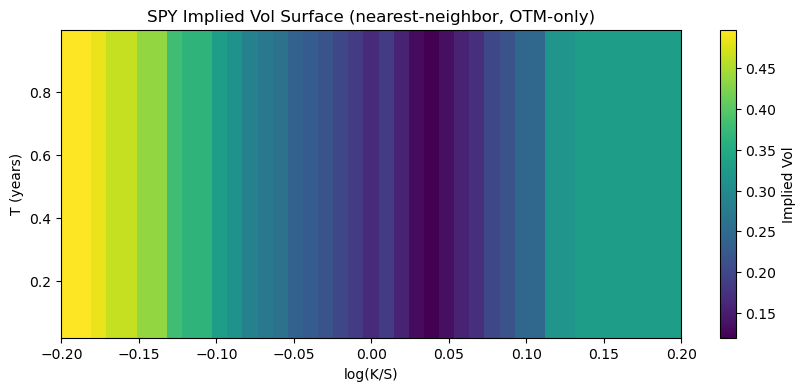

In [ ]:
#1d heatmap plot of the surface
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(surface, aspect="auto", origin="lower",
           extent=[m_grid.min(), m_grid.max(), T_grid.min(), T_grid.max()])
plt.colorbar(label="Implied Vol")
plt.xlabel("log(K/S)")
plt.ylabel("T (years)")
plt.title("SPY Implied Vol Surface (nearest-neighbor, OTM-only)")
plt.show()


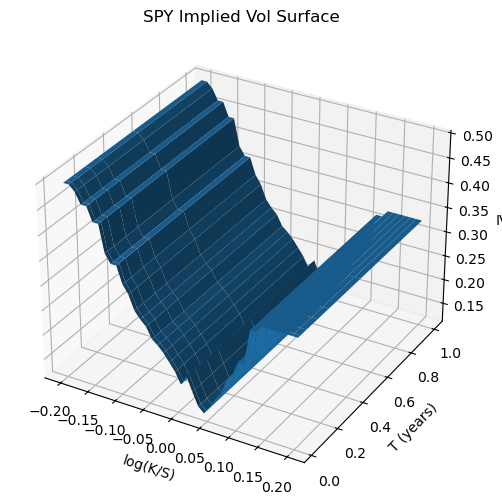

In [ ]:
#3d non-interactive plot example
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

M, TT = np.meshgrid(m_grid, T_grid)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(M, TT, surface, linewidth=0, antialiased=True)
ax.set_xlabel("log(K/S)")
ax.set_ylabel("T (years)")
ax.set_zlabel("IV")
ax.set_title("SPY Implied Vol Surface")
plt.show()


In [27]:
# 3D interactive plot with plotly

import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Surface(
        x=m_grid,          # x-axis: log-moneyness
        y=T_grid,          # y-axis: maturity
        z=surface          # z-axis: IV
    )]
)

fig.update_layout(
    title="SPY Implied Vol Surface (interactive)",
    scene=dict(
        xaxis_title="log(K/S)",
        yaxis_title="T (years)",
        zaxis_title="IV"
    ),
    width=900,
    height=600,
)

fig.show()


KeyError: 'm'